# Python user, leveraging SAS - Readmission Prediction

## Load packages

In [1]:
#Import packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import IFrame
import pygal

#SAS packages
import swat

In [2]:
import getpass
pwd = getpass.getpass()

········


## Set up a connection with CAS

In [3]:
# Set up a connection with CAS #
conn=swat.CAS('https://demo.sasdemo.ca/cas-shared-default-http/',5570,'marie',pwd)
conn.about()
conn.serverstatus()

NOTE: Grid node action status report: 1 nodes, 9 total actions executed.
NOTE: Grid node action status report: 1 nodes, 10 total actions executed.


[About]

 {'CAS': 'Cloud Analytic Services',
  'Copyright': 'Copyright Â© 2014-2018 SAS Institute Inc. All Rights Reserved.',
  'ServerTime': '2021-03-02T14:43:30Z',
  'System': {'Hostname': 'va82-12.capresales.local',
   'Linux Distribution': 'Red Hat Enterprise Linux Server release 7.8 (Maipo)',
   'Model Number': 'x86_64',
   'OS Family': 'LIN X64',
   'OS Name': 'Linux',
   'OS Release': '3.10.0-1127.13.1.el7.x86_64',
   'OS Version': '#1 SMP Fri Jun 12 14:34:17 EDT 2020'},
  'Version': '3.05',
  'VersionLong': 'V.03.05M0P11112019',
  'license': {'expires': '30Mar2021:00:00:00',
   'gracePeriod': 45,
   'maxCPUs': 9999,
   'site': 'iHUB 3.5 full order v2',
   'siteNum': 70180938,
   'warningPeriod': 45}}

[nodestatus]

 Node Status
 
                        name        role  uptime  running  stalled
 0  va82-12.capresales.local  controller   3.652        0        0

[server]

 Server Status
 
    nodes  actions
 0      1       10

+ Elapsed: 0.00122s, user: 2.6e-05s, sys: 0.0011s, mem: 0.277mb

## Access data in CAS

In [4]:
#Load data from CAS
castbl=conn.CASTable(name='READMISSIONS_MODEL2',caslib="Public")
indata = 'READMISSIONS_MODEL2'
display(castbl.shape)
castbl.describe(include=['numeric','character'])

(75675, 18)

,Readmitted,Admit_Date,Diagnosis,Length_of_Stay,Prior_IP_Admits,Chronic_Conditions_Number,Patient_Age,Order_Set_Used,Total_Charges,Discharge_Notes,Patient_Gender,Urban_Class,Marital_Status,Repeat_Care_Offenders,High_NA_at_Discharge,bmi,Contact_Preference,_PARTIND_
count,75675,75675,75675,75675,75675,75675,75675,75675,75675,75675,75675,75675,75675,75675,75675,75675,75675,75675
unique,2,1095,6,28,7,7,102,2,50882,6,2,2,2,2,2,271,4,3
top,0,14-Sep-14,HIP/KNEE,4,4,2,55,0,11795,"ROUTINE DSCHG, HOME",M,U,Y,N,N,24.6,phone,1
freq,58668,103,20043,17200,35079,63288,2530,45443,10,56655,43864,59782,47600,64279,50487,914,26549,45405
mean,NaN,NaN,NaN,4.8166,4.49643,2.01574,58.088,0.399498,17527.4,NaN,NaN,NaN,NaN,NaN,NaN,24.5087,NaN,0.800198
std,NaN,NaN,NaN,2.77931,0.642059,0.473332,13.0111,0.489798,14557.7,NaN,NaN,NaN,NaN,NaN,NaN,3.50004,NaN,0.60007
min,0,1-Apr-14,AMI,0,2,0,13,0,1.25,DSCHG HOSPICE,F,R,N,N,N,7.3,email,0
25%,NaN,NaN,NaN,3,4,2,49,0,8674.4,NaN,NaN,NaN,NaN,NaN,NaN,22.1,NaN,0
50%,NaN,NaN,NaN,4,4,2,57,0,13242.5,NaN,NaN,NaN,NaN,NaN,NaN,24.5,NaN,1
75%,NaN,NaN,NaN,6,5,2,66,1,21345,NaN,NaN,NaN,NaN,NaN,NaN,26.9,NaN,1


## Explore & Prepare Data for Modeling

In [5]:
#Get info of all variables
colinfo=conn.table.columninfo(table=castbl)['ColumnInfo']
colinfo

,Column,Label,ID,Type,RawLength,FormattedLength,Format,NFL,NFD
0,Readmitted,,1,varchar,16,16,$CHAR,16,0
1,Admit_Date,,2,varchar,9,9,,0,0
2,Diagnosis,,3,varchar,8,8,,0,0
3,Length_of_Stay,,4,double,8,12,,0,0
4,Prior_IP_Admits,,5,double,8,12,,0,0
5,Chronic_Conditions_Number,,6,double,8,12,,0,0
6,Patient_Age,,7,double,8,12,,0,0
7,Order_Set_Used,,8,double,8,12,,0,0
8,Total_Charges,,9,double,8,12,,0,0
9,Discharge_Notes,,10,varchar,20,20,,0,0


In [6]:
#Load CAS Action set: simple >> to calculate summary
conn.loadActionSet('simple')
actions=conn.builtins.help(actionSet='simple')



NOTE: Added action set 'simple'.
NOTE: Information for action set 'simple':
NOTE:    simple
NOTE:       mdSummary - Calculates multidimensional summaries of numeric variables
NOTE:       numRows - Shows the number of rows in a Cloud Analytic Services table
NOTE:       summary - Generates descriptive statistics of numeric variables such as the sample mean, sample variance, sample size, sum of squares, and so on
NOTE:       correlation - Computes Pearson product-moment correlations.
NOTE:       regression - Performs a linear regression up to 3rd-order polynomials
NOTE:       crossTab - Performs one-way or two-way tabulations
NOTE:       distinct - Computes the distinct number of values of the variables in the variable list
NOTE:       topK - Returns the top-K and bottom-K distinct values of each variable included in the variable list based on a user-specified ranking order
NOTE:       groupBy - Builds BY groups in terms of the variable value combinations given the variables in the variab

In [7]:
#Correlation
conn.simple.correlation(
table=castbl,
inputs= ['Readmitted', 'bmi','Length_of_Stay', 'Patient_Age', 'Total_Charges'])

ERROR: The variable Readmitted in table READMISSIONS_MODEL2 must be numeric for this analysis.
ERROR: The action stopped due to errors.


+ Elapsed: 0.00171s, user: 0.00131s, sys: 0.000261s, mem: 0.536mb

## Set Target and Input Variables
Predict likelihood of credit card debt being written off

In [8]:
#Set target variable
target='Readmitted'

In [9]:
#Set inputs
inputs=list(['bmi', 'Chronic_Conditions_Number', 'Diagnosis', 'Discharge_Notes', 'High_NA_at_Discharge', 'Length_of_Stay', 
            'Marital_Status', 'Order_Set_Used', 'Patient_Age', 'Patient_Gender', 'Prior_IP_Admits', 
            'Repeat_Care_Offenders', 'Total_Charges', 'Urban_Class', 'Contact_Preference'])
nominals=list(['Chronic_Conditions_Number', 'Diagnosis', 'Discharge_Notes', 'High_NA_at_Discharge',
            'Marital_Status', 'Order_Set_Used', 'Patient_Gender',  
            'Repeat_Care_Offenders', 'Urban_Class', 'Contact_Preference'])
nominals = [target] + nominals

## Train Models

### SVM

In [10]:
#Load action set
conn.loadActionSet('svm')
actions=conn.builtins.help(actionSet='svm')

NOTE: Added action set 'svm'.
NOTE: Information for action set 'svm':
NOTE:    svm
NOTE:       svmTrain - Provides actions for support vector machines


In [11]:
#Build SVM model
conn.svm.svmTrain(
table=dict(name=castbl, where='_PARTIND_=1'), #training data
target=target,
inputs=inputs,
nominals=nominals[1:],
kernel="polynomial",
degree=2,
savestate=dict(name="svm_readmit_swat",replace=True, caslib = 'Public'))

NOTE: SVM training is activated.
NOTE: 17253 bytes were written to the table "svm_readmit_swat" in the caslib "Public".


[FitStatistics]

 Fit Statistics
 
      Statistic  Training
 0     Accuracy  0.959872
 1        Error  0.040128
 2  Sensitivity  0.987045
 3  Specificity  0.866144

[IterHistory]

 Iteration History
 
     Iteration  Complementarity   Feasibility
 0         1.0     1.002352e+06  4.144055e+07
 1         2.0     1.366115e+03  3.587582e+04
 2         3.0     2.875809e+02  3.183722e+03
 3         4.0     2.703572e+01  1.944361e+02
 4         5.0     1.493752e+01  9.568163e+01
 5         6.0     7.434618e+00  3.984048e+01
 6         7.0     4.608200e+00  1.904576e+01
 7         8.0     2.045805e+00  4.619266e+00
 8         9.0     1.093275e+00  2.093518e+00
 9        10.0     5.051387e-01  7.410706e-01
 10       11.0     4.901536e-01  7.411202e-09
 11       12.0     1.851756e-01  2.041303e-09
 12       13.0     1.472042e-01  1.392056e-09
 13       14.0     1.143103e-01  8.646668e-10
 14       15.0     8.819754e-02  5.828547e-10
 15       16.0     7.612760e-02  4.596536e-10
 16       17.0     6.211355e-02  3.346863e-10
 17       18.0     5.362172e-02  2.546441e-10
 18       19.0     4.565414e-02  1.595644e-10
 19       20.0     3.683191e-02  8.975576e-11
 20       21.0     3.203797e-02  7.050938e-11
 21       22.0     2.624937e-02  4.446221e-11
 22       23.0     2.209849e-02  2.444944e-11
 23       24.0     1.908748e-02  1.508504e-11
 24       25.0     1.640650e-02  8.305134e-12

[Misclassification]

 Misclassification Matrix
 
   Observed  PredEvent  PredNonEvent  TotalTrain
 0        0    34744.0         456.0     35200.0
 1        1     1366.0        8839.0     10205.0
 2    Total    36110.0        9295.0     45405.0

[ModelInfo]

 Model Information
 
            RowId                   Descr           Value     NValue
 0       TaskType               Task Type          C_CLAS        NaN
 1         Method  Optimization Technique  Interior Point        NaN
 2          Scale                   Scale             YES        NaN
 3         Kernel         Kernel Function      Polynomial        NaN
 4         degree           Kernel Degree               2   2.000000
 5  PenaltyMethod          Penalty Method               C        NaN
 6              C       Penalty Parameter               1   1.000000
 7        MaxIter      Maximum Iterations              25  25.000000
 8      Tolerance               Tolerance           1e-06   0.000001

[NObs]

 Observations
 
                          Descr        N
 0  Number of Observations Read  45405.0
 1  Number of Observations Used  45405.0

[TrainingResult]

 Training Results
 
           RowId                                Descr         Value
 0            WW             Inner Product of Weights    415.072425
 1          Beta                                 Bias     -2.170304
 2    TotalSlack  Total Slack (Constraint Violations)   5603.438833
 3    LongVector               Norm of Longest Vector     13.313124
 4      nSupport            Number of Support Vectors  45405.000000
 5   nSupportInM  Number of Support Vectors on Margin      0.000000
 6      MaximumF                            Maximum F     23.622774
 7      MinimumF                            Minimum F     -8.879997
 8      nEffects                    Number of Effects     15.000000
 9       nLevels               Columns in Data Matrix     40.000000
 10   MatrixSize             Columns in Kernel Matrix    861.000000

+ Elapsed: 8.21s, user: 94.8s, sys: 7.46s, mem: 945mb

### Decision Tree

In [12]:
#Load action set
conn.loadActionSet('decisionTree')
actions=conn.builtins.help(actionSet='decisionTree')

NOTE: Added action set 'decisionTree'.
NOTE: Information for action set 'decisionTree':
NOTE:    decisionTree
NOTE:       dtreeTrain - Trains a decision tree
NOTE:       dtreeScore - Scores a table using a decision tree model
NOTE:       dtreeSplit - Splits decision tree nodes
NOTE:       dtreePrune - Prune a decision tree
NOTE:       dtreeMerge - Merges decision tree nodes
NOTE:       dtreeCode - Generates DATA step scoring code from a decision tree model
NOTE:       forestTrain - Trains a forest. This action requires a SAS Visual Data Mining and Machine Learning license
NOTE:       forestScore - Scores a table using a forest model
NOTE:       forestCode - Generates DATA step scoring code from a forest model
NOTE:       gbtreeTrain - Trains a gradient boosting tree. This action requires a SAS Visual Data Mining and Machine Learning license
NOTE:       gbtreeScore - Scores a table using a gradient boosting tree model
NOTE:       gbtreeCode - Generates DATA step scoring code from a grad

In [13]:
#Build a decision tree model
conn.decisionTree.dtreeTrain(
table=dict(name=castbl, where="_PARTIND_=1"),
target=target,
inputs=inputs,
nominals=nominals[1:],
casOut=dict(name="dtree_readmit_swat",replace=True,caslib = 'Public'))

,Descr,Value
0,Number of Tree Nodes,19.000000
1,Max Number of Branches,2.000000
2,Number of Levels,6.000000
3,Number of Leaves,10.000000
4,Number of Bins,50.000000
5,Minimum Size of Leaves,6.000000
6,Maximum Size of Leaves,36174.000000
7,Number of Variables,15.000000
8,Confidence Level for Pruning,0.250000
9,Number of Observations Used,45405.000000


### Random Forest

In [14]:
#Build RF model
conn.decisionTree.forestTrain(
table=dict(name=castbl, where="_PARTIND_=1"),
target=target,
inputs=inputs,
nominals=nominals[1:],
ntree=1000,
casOut=dict(name="rf_readmit_swat",replace=True, caslib = 'Public'))

,Descr,Value
0,Number of Trees,1000.000000
1,Number of Selected Variables (M),4.000000
2,Random Number Seed,0.000000
3,Bootstrap Percentage (%),63.212056
4,Number of Bins,50.000000
5,Number of Variables,15.000000
6,Confidence Level for Pruning,0.250000
7,Max Number of Tree Nodes,61.000000
8,Min Number of Tree Nodes,15.000000
9,Max Number of Branches,2.000000


### Gradient Boosting

In [15]:
#Build Gradient Boosting model
conn.decisionTree.gbtreeTrain(
table=dict(name= castbl, where="_PARTIND_=1"),
target=target,
inputs=inputs,
nominals=nominals[1:],
ntree=1000,
casOut=dict(name="gb_readmit_swat",replace=True, caslib = 'Public'),
savestate=dict(name='gb_readmit_trained',replace=True, caslib = 'Public'))

NOTE: 21479409 bytes were written to the table "gb_readmit_trained" in the caslib "Public".


,Descr,Value
0,Number of Trees,1000.000
1,Distribution,2.000
2,Learning Rate,0.100
3,Subsampling Rate,0.500
4,Number of Selected Variables (M),15.000
5,Number of Bins,50.000
6,Number of Variables,15.000
7,Max Number of Tree Nodes,31.000
8,Min Number of Tree Nodes,15.000
9,Max Number of Branches,2.000


### Gradient Boosting with Autotune

In [16]:
#load action set
conn.loadActionSet('autotune')
actions=conn.builtins.help(actionSet='autotune')

NOTE: Added action set 'autotune'.
NOTE: Information for action set 'autotune':
NOTE:    autotune
NOTE:       tuneSvm - Automatically adjusts support vector machine parameters to tune a model for minimum error
NOTE:       tuneForest - Automatically adjusts forest parameters to tune a model for minimum error
NOTE:       tuneDecisionTree - Automatically adjusts decision tree parameters to tune a model for minimum error
NOTE:       tuneNeuralNet - Automatically adjusts neural network parameters to tune a model for minimum error
NOTE:       tuneGradientBoostTree - Automatically adjusts gradient boosting tree parameters to tune a model for minimum error
NOTE:       tuneFactMac - Automatically adjusts factorization machine parameters to tune a model for minimum error
NOTE:       tuneBnet - Automatically adjusts Bayesian network classifier parameters to tune a model for minimum error
NOTE:       tuneTsne - Automatically adjusts t-Distributed Stochastic Neighbor Embedding algorithm parameters 

In [17]:
conn.autotune.tuneGradientBoostTree(
trainOptions=dict(
table=dict(name= indata, where="_PARTIND_=1", caslib = 'Public'),
target=target,
inputs=inputs,
nominals= nominals,
casOut=dict(name='gb_tuned_readmit_swat',replace=True)),
tunerOptions=dict(seed=802, maxEvals=10,maxTime=30))

NOTE: Autotune is started for 'Gradient Boosting Tree' model.
NOTE: Autotune option SEARCHMETHOD='GA'.
NOTE: Autotune option MAXEVALS=10.
NOTE: Autotune option MAXTIME=30 (sec.).
NOTE: Autotune option SEED=802.
NOTE: Autotune objective is 'Misclassification Error Percentage'.
NOTE: Early stopping is activated; 'NTREE' will not be tuned.
NOTE: Autotune number of parallel evaluations is set to 4, each using 0 worker nodes.
NOTE: Automatic early stopping is activated with STAGNATION=4;  set EARLYSTOP=false to deactivate.
         Iteration       Evals     Best Objective  Elapsed Time
                 0           1             3.4506          2.05
                 1          25             3.4506         29.12
NOTE: Data was partitioned during tuning, to tune based on validation score; the final model is trained and scored on all data.
NOTE: The number of trees used in the final model is 150.
NOTE: Autotune time is 33.36 seconds.


[BestConfiguration]

 Best Configuration
 
                             Parameter           Name Value
 0                          Evaluation     Evaluation     0
 1          Number of Variables to Try              M    15
 2                       Learning Rate   LEARNINGRATE   0.1
 3                       Sampling Rate  SUBSAMPLERATE   0.5
 4                               Lasso          LASSO     0
 5                               Ridge          RIDGE     1
 6                      Number of Bins          NBINS    50
 7                 Maximum Tree Levels       MAXLEVEL     5
 8  Misclassification Error Percentage      Objective  3.45

[ErrorMetricInfo]

      TreeID  Trees  NLeaves       MCR   LogLoss       ASE      RASE     MAXAE
 0       0.0    1.0     14.0  0.224755  0.470613  0.150896  0.388453  0.794639
 1       1.0    2.0     30.0  0.224755  0.425831  0.132616  0.364164  0.811405
 2       2.0    3.0     44.0  0.224755  0.390900  0.118055  0.343591  0.827755
 3       3.0    4.0     59.0  0.217135  0.362273  0.106104  0.325736  0.842083
 4       4.0    5.0     75.0  0.100540  0.337469  0.095943  0.309746  0.855420
 ..      ...    ...      ...       ...       ...       ...       ...       ...
 145   145.0  146.0   2186.0  0.031428  0.090240  0.024454  0.156379  0.999120
 146   146.0  147.0   2202.0  0.031340  0.090159  0.024436  0.156321  0.999129
 147   147.0  148.0   2218.0  0.031494  0.090078  0.024419  0.156266  0.999133
 148   148.0  149.0   2233.0  0.031384  0.089956  0.024391  0.156175  0.999149
 149   149.0  150.0   2249.0  0.031340  0.089879  0.024371  0.156111  0.999210
 
 [150 rows x 8 columns]

[EvalMetricInfo]

      Progress    Metric
 0         1.0  0.224755
 1         2.0  0.224755
 2         3.0  0.224755
 3         4.0  0.217135
 4         5.0  0.100540
 ..        ...       ...
 145     146.0  0.031428
 146     147.0  0.031340
 147     148.0  0.031494
 148     149.0  0.031384
 149     150.0  0.031340
 
 [150 rows x 2 columns]

[EvaluationHistory]

 Tuner Evaluation History
 
     Evaluation  Iteration   M  LEARNINGRATE  SUBSAMPLERATE      LASSO  \
 0            0          0  15         0.100           0.50   0.000000   
 1            1          1   9         0.560           0.40   5.555556   
 2            2          1   1         0.780           0.90   4.444444   
 3            3          1   7         1.000           0.10   2.222222   
 4            4          1   3         0.230           0.30   7.777778   
 5            5          1  10         0.340           0.50   1.111111   
 6            6          1   4         0.010           0.70  10.000000   
 7            7          1  13         0.120           0.60   6.666667   
 8            8          1  12         0.670           0.80   8.888889   
 9            9          1  15         0.450           0.20   0.000000   
 10          10          1  15         0.100           0.50   0.000000   
 11          11          1   8         0.505           0.55   5.000000   
 12          12          1  15         0.505           0.55   5.000000   
 13          13          1   1         0.505           0.55   5.000000   
 14          14          1   8         1.000           0.55   5.000000   
 15          15          1   8         0.010           0.55   5.000000   
 16          16          1   8         0.505           1.00   5.000000   
 17          17          1   8         0.505           0.10   5.000000   
 18          18          1   8         0.505           0.55  10.000000   
 19          19          1   8         0.505           0.55   0.000000   
 20          20          1   8         0.505           0.55   5.000000   
 21          21          1   8         0.505           0.55   5.000000   
 22          22          1   8         0.505           0.55   5.000000   
 23          23          1   8         0.505           0.55   5.000000   
 24          24          1   8         0.505           0.55   5.000000   
 25          25          1   8         0.505

## Scoring the Models

In [18]:
#Load action set astore
conn.loadActionSet('aStore')
actions=conn.builtins.help(actionSet='aStore')

NOTE: Added action set 'aStore'.
NOTE: Information for action set 'aStore':
NOTE:    astore
NOTE:       download - Downloads a remote store to a local store
NOTE:       upload - Uploads a local store to a remote store
NOTE:       describe - Describes some of the contents of the analytic store
NOTE:       score - Uses an analytic store to score an input table


In [19]:
#Score SVM
conn.aStore.score(
table=dict(name=castbl, where="_PARTIND_=0"),#scoring
rstore=dict(name="svm_readmit_swat",caslib = 'Public'),
copyVars=target,
out=dict(name="svm_scored_readmit_swat",replace=True, caslib= 'Public'))

[OutputCasTables]

    casLib                     Name   Rows  Columns  \
 0  Public  svm_scored_readmit_swat  22695        6   
 
                                             casTable  
 0  CASTable('svm_scored_readmit_swat', caslib='Pu...  

[Timing]

 Task Timing
 
                  Task   Seconds   Percent
 0   Loading the Store  0.000176  0.006072
 1  Creating the State  0.005932  0.204725
 2             Scoring  0.022323  0.770393
 3               Total  0.028976  1.000000

+ Elapsed: 0.0335s, user: 0.298s, sys: 0.0232s, mem: 76mb

In [20]:
#Score decision tree
conn.decisionTree.dTreeScore(
table=dict(name=castbl, where="_PARTIND_=0"),
model=dict(name="dtree_readmit_swat",caslib = 'Public'),
casout=dict(name="dtree_scored_readmit_swat",replace=True, caslib = 'Public'),
copyVars=target,
encodename=True,
assessonerow=True)

[EncodedName]

             LEVNAME  LEVINDEX        VARNAME
 0                 1         0  P_Readmitted1
 1                 0         1  P_Readmitted0

[EncodedTargetName]

   LEVNAME  LEVINDEX       VARNAME
 0                 0  I_Readmitted

[OutputCasTables]

    casLib                       Name   Rows  Columns  \
 0  Public  dtree_scored_readmit_swat  22695       13   
 
                                             casTable  
 0  CASTable('dtree_scored_readmit_swat', caslib='...  

[ScoreInfo]

                          Descr                             Value
 0  Number of Observations Read                             22695
 1  Number of Observations Used                             22695
 2  Misclassification Error (%)                      8.7640449438

+ Elapsed: 0.0323s, user: 0.0572s, sys: 0.023s, mem: 71.3mb

In [21]:
#Score RF
conn.decisionTree.forestScore(
table=dict(name=castbl, where="_PARTIND_=0"),
model=dict(name="rf_readmit_swat",caslib = 'Public'),
casout=dict(name="rf_scored_readmit_swat",replace=True, caslib = 'Public'),
copyVars=target,
encodename=True,
assessonerow=True)

[EncodedName]

             LEVNAME  LEVINDEX        VARNAME
 0                 1         0  P_Readmitted1
 1                 0         1  P_Readmitted0

[EncodedTargetName]

   LEVNAME  LEVINDEX       VARNAME
 0                 0  I_Readmitted

[OutputCasTables]

    casLib                    Name   Rows  Columns  \
 0  Public  rf_scored_readmit_swat  22695        6   
 
                                             casTable  
 0  CASTable('rf_scored_readmit_swat', caslib='Pub...  

[ScoreInfo]

                          Descr                             Value
 0  Number of Observations Read                             22695
 1  Number of Observations Used                             22695
 2  Misclassification Error (%)                      8.1295439524

+ Elapsed: 0.971s, user: 16.9s, sys: 1.26s, mem: 656mb

In [22]:
#Score Gradient Boosting
conn.decisionTree.gbtreeScore(
table=dict(name=castbl, where="_PARTIND_=0"),
model=dict(name="gb_readmit_swat",caslib = 'Public'),
casout=dict(name="gb_scored_readmit_swat",replace=True,caslib='Public'),
copyVars=target,
encodename=True,
assessonerow=True)

[EncodedName]

             LEVNAME  LEVINDEX        VARNAME
 0                 1         0  P_Readmitted1
 1                 0         1  P_Readmitted0

[EncodedTargetName]

   LEVNAME  LEVINDEX       VARNAME
 0                 0  I_Readmitted

[ErrorMetricInfo]

      TreeID   Trees  NLeaves       MCR   LogLoss       ASE      RASE     MAXAE
 0       0.0     1.0     15.0  0.224323  0.469306  0.150344  0.387742  0.794355
 1       1.0     2.0     30.0  0.224323  0.420121  0.130481  0.361221  0.813420
 2       2.0     3.0     46.0  0.224323  0.382447  0.114931  0.339014  0.828687
 3       3.0     4.0     60.0  0.222780  0.353935  0.103040  0.320998  0.843144
 4       4.0     5.0     75.0  0.099625  0.330443  0.093481  0.305747  0.856324
 ..      ...     ...      ...       ...       ...       ...       ...       ...
 995   995.0   996.0  15600.0  0.036396  0.109084  0.028445  0.168657  0.999934
 996   996.0   997.0  15616.0  0.036484  0.109106  0.028453  0.168679  0.999934
 997   997.0   998.0  15632.0  0.036352  0.109150  0.028457  0.168693  0.999933
 998   998.0   999.0  15648.0  0.036219  0.109093  0.028433  0.168620  0.999935
 999   999.0  1000.0  15664.0  0.036308  0.109119  0.028440  0.168642  0.999935
 
 [1000 rows x 8 columns]

[OutputCasTables]

    casLib                    Name   Rows  Columns  \
 0  Public  gb_scored_readmit_swat  22695        5   
 
                                             casTable  
 0  CASTable('gb_scored_readmit_swat', caslib='Pub...  

[ScoreInfo]

                          Descr                             Value
 0  Number of Observations Read                             22695
 1  Number of Observations Used                             22695
 2  Misclassification Error (%)                      3.6307556731

+ Elapsed: 1.27s, user: 26.1s, sys: 0.391s, mem: 251mb

## Model Assessment

In [23]:
#Load action set
conn.loadActionSet('percentile')
actions=conn.builtins.help(actionSet='percentile')

NOTE: Added action set 'percentile'.
NOTE: Information for action set 'percentile':
NOTE:    percentile
NOTE:       percentile - Calculate quantiles and percentiles
NOTE:       boxPlot - Calculate quantiles, high and low whiskers, and outliers
NOTE:       assess - Assess and compare models


In [24]:
gb_test = conn.CASTable(name='gb_scored_readmit_swat', caslib='Public')
gb_test.describe(include=['numeric','character'])

,Readmitted,I_Readmitted,_MissIt_,P_Readmitted1,P_Readmitted0
count,22695,22695,22695,22695,22695
unique,2,2,2,22693,22693
top,0,0,0,0.000170518,0.99994
freq,17604,17902,21871,2,2
mean,NaN,NaN,0.0363076,0.222732,0.777268
std,NaN,NaN,0.187058,0.388323,0.388323
min,0,0,0,1.18439e-06,8.57714e-10
25%,NaN,NaN,0,0.00089884,0.850921
50%,NaN,NaN,0,0.00662727,0.993373
75%,NaN,NaN,0,0.149079,0.999101


In [25]:
#Create prediction variable name
assess_input='P_'+target+'1'
#assess_input='P_DV_Readmit_Flag'
# Assess SVM
svm_assess=conn.percentile.assess(
table= dict(name ='svm_scored_readmit_swat', caslib = 'Public'),
inputs=assess_input,
casout=dict(name="svm_assess_readmit_swat", replace=True, caslib = 'Public'),
response=target,
event= '1')

#Assess decision tree
dt_assess=conn.percentile.assess(
table=dict(name = 'dtree_scored_readmit_swat', caslib = 'Public'),
inputs=assess_input,
casout=dict(name="dtree_assess_readmit_swat", replace=True, caslib = 'Public'),
response=target,
event= '1')

#Assess forest
rf_assess=conn.percentile.assess(
table=dict(name='rf_scored_readmit_swat', caslib = 'Public'),
inputs=assess_input,
casout=dict(name="rf_assess_readmit_swat", replace=True, caslib = 'Public'),
response=target,
event= '1')

#Assess gradient boosting
gb_assess=conn.percentile.assess(
table=dict(name='gb_scored_readmit_swat',caslib = 'Public'),
inputs=assess_input,
casout=dict(name="gb_assess_readmit_swat", replace=True, caslib = 'Public'),
response=target,
event= '1')

In [26]:
display(conn.table.fetch(table=dict(name='gb_assess_readmit_swat',caslib = 'Public'),to=5,))
conn.table.fetch(table=dict(name='gb_assess_readmit_swat_ROC',caslib = 'Public'),to=5)

,_Column_,_Event_,_Depth_,_Value_,_NObs_,_NEvents_,_NEventsBest_,_Resp_,_RespBest_,_Lift_,...,_CumResp_,_CumRespBest_,_CumLift_,_CumLiftBest_,_PctResp_,_PctRespBest_,_CumPctResp_,_CumPctRespBest_,_Gain_,_GainBest_
0,P_Readmitted1,1,5.0,0.999977,1135.0,1135.0,1135.0,22.294245,22.294245,4.458849,...,22.294245,22.294245,4.458849,4.458849,100.000000,100.000000,100.000000,100.000000,3.458849,3.458849
1,P_Readmitted1,1,10.0,0.999711,1135.0,1135.0,1135.0,22.294245,22.294245,4.458849,...,44.588489,44.588489,4.458849,4.458849,100.000000,100.000000,100.000000,100.000000,3.458849,3.458849
2,P_Readmitted1,1,15.0,0.993361,1135.0,1131.0,1135.0,22.215675,22.294245,4.443135,...,66.804164,66.882734,4.453611,4.458849,99.647577,100.000000,99.882526,100.000000,3.453611,3.458849
3,P_Readmitted1,1,20.0,0.690531,1135.0,992.0,1135.0,19.485366,22.294245,3.897073,...,86.289531,89.176979,4.314477,4.458849,87.400881,100.000000,96.762115,100.000000,3.314477,3.458849
4,P_Readmitted1,1,25.0,0.148801,1135.0,382.0,551.0,7.503437,10.823021,1.500687,...,93.792968,100.000000,3.751719,4.000000,33.656388,48.546256,84.140969,89.709251,2.751719,3.000000


,_Column_,_Event_,_Cutoff_,_TP_,_FP_,_FN_,_TN_,_Sensitivity_,_Specificity_,_KS_,...,_FHALF_,_FPR_,_ACC_,_FDR_,_F1_,_C_,_GINI_,_GAMMA_,_TAU_,_MiscEvent_
0,P_Readmitted1,1,0.00,5091.0,17604.0,0.0,0.0,1.000000,0.000000,0.0,...,0.265513,1.000000,0.224323,0.775677,0.366444,0.981792,0.963584,0.975655,0.335346,0.775677
1,P_Readmitted1,1,0.01,5015.0,5205.0,76.0,12399.0,0.985072,0.704329,0.0,...,0.545453,0.295671,0.767306,0.509295,0.655085,0.981792,0.963584,0.975655,0.335346,0.232694
2,P_Readmitted1,1,0.02,4963.0,3592.0,128.0,14012.0,0.974858,0.795955,0.0,...,0.631248,0.204045,0.836087,0.419871,0.727393,0.981792,0.963584,0.975655,0.335346,0.163913
3,P_Readmitted1,1,0.03,4935.0,2831.0,156.0,14773.0,0.969358,0.839184,0.0,...,0.682478,0.160816,0.868385,0.364538,0.767675,0.981792,0.963584,0.975655,0.335346,0.131615
4,P_Readmitted1,1,0.04,4917.0,2317.0,174.0,15287.0,0.965822,0.868382,0.0,...,0.722514,0.131618,0.890240,0.320293,0.797890,0.981792,0.963584,0.975655,0.335346,0.109760


## Bring Assessment Tables Local and work with Python Packages

In [27]:
#Add ROC assessment results into data frames

svm_assess_ROC=conn.CASTable(name="svm_assess_readmit_swat_ROC", caslib = 'Public')
svm_assess_ROC=svm_assess_ROC.to_frame()
svm_assess_ROC['Model']='Support Vector Machine'

dtree_assess_ROC=conn.CASTable(name="dtree_assess_readmit_swat_ROC", caslib = 'Public')
dtree_assess_ROC=dtree_assess_ROC.to_frame()
dtree_assess_ROC['Model']='Decision Tree'

rf_assess_ROC=conn.CASTable(name="rf_assess_readmit_swat_ROC", caslib = 'Public')
rf_assess_ROC=rf_assess_ROC.to_frame()
rf_assess_ROC['Model']='Forest'

gb_assess_ROC=conn.CASTable(name="gb_assess_readmit_swat_ROC", caslib = 'Public')
gb_assess_ROC=gb_assess_ROC.to_frame()
gb_assess_ROC['Model']='Gradient Boosting'


## Model Comparison & Assessment (Locally)

In [28]:
df_assess=pd.DataFrame()
df_assess=pd.concat([svm_assess_ROC,dtree_assess_ROC,rf_assess_ROC,
                   gb_assess_ROC])
cutoff_index=round(df_assess['_Cutoff_'],2)==0.5
compare=df_assess[cutoff_index].reset_index(drop=True)
compare['Misclassification']=1-compare['_ACC_']
compare[['Model','_TP_','_FP_','_TN_','_FN_','_C_','Misclassification']] 
#Gradient Boosting is the best model

,Model,_TP_,_FP_,_TN_,_FN_,_C_,Misclassification
0,Support Vector Machine,4405.0,211.0,17393.0,686.0,0.978436,0.039524
1,Decision Tree,3497.0,395.0,17209.0,1594.0,0.855728,0.087640
2,Forest,3318.0,72.0,17532.0,1773.0,0.956796,0.081295
3,Gradient Boosting,4530.0,263.0,17341.0,561.0,0.981792,0.036308


In [29]:
compare['Misclassification']=1-compare['_ACC_']
miss=compare[round(compare['_Cutoff_'],2)==0.5][['Model','Misclassification']]

['Support Vector Machine', 'Decision Tree', 'Forest', 'Gradient Boosting']

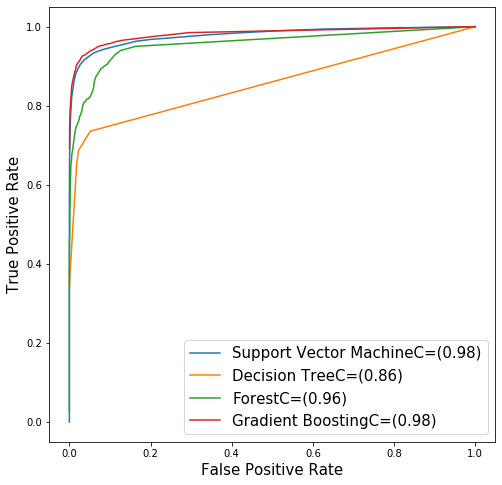

In [30]:
plt.figure(figsize=(8,8))
plt.plot()
models=list(df_assess.Model.unique())
display(models)

#Iteratively add each curve into the plot
for X in models:
    tmp=df_assess[df_assess['Model']==X]
    plt.plot(tmp['_FPR_'],tmp['_Sensitivity_'],label=X+'C=(%0.2f)'%tmp['_C_'].mean())
    
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.legend(loc='lower right', fontsize=15)
plt.show()

## Save the best model into casuser caslib

In [31]:
#Save the trained model
conn.table.save(caslib='Public',
                table=dict(name='gb_readmit_swat', caslib = 'Public'),name='GB_Readmit_SWAT',replace=True)

NOTE: Cloud Analytic Services saved the file GB_Readmit_SWAT.sashdat in caslib Public.


[caslib]

 'Public'

[name]

 'GB_Readmit_SWAT.sashdat'

+ Elapsed: 0.281s, user: 0.00869s, sys: 0.0364s, mem: 16.6mb

In [32]:
#Save the trained model
conn.table.save(caslib='Public',
                table=dict(name='dtree_readmit_swat', caslib = 'Public'),name='DTree_Readmit_SWAT',replace=True)

NOTE: Cloud Analytic Services saved the file DTree_Readmit_SWAT.sashdat in caslib Public.


[caslib]

 'Public'

[name]

 'DTree_Readmit_SWAT.sashdat'

+ Elapsed: 0.0345s, user: 0.00234s, sys: 0.00223s, mem: 16.6mb

In [33]:
#Save attributes
conn.table.attribute(caslib='Public',table='GB_Readmit_SWAT_attr',name='gb_readmit_swat',task='convert')
conn.table.save(caslib='Public',table= dict(name='GB_Readmit_SWAT_attr', caslib = 'Public'), name='GB_Readmit_SWAT_attr', replace=True)

NOTE: Cloud Analytic Services saved the file GB_Readmit_SWAT_attr.sashdat in caslib Public.


[caslib]

 'Public'

[name]

 'GB_Readmit_SWAT_attr.sashdat'

+ Elapsed: 0.0344s, user: 0.000634s, sys: 0.00205s, mem: 16.6mb

In [34]:
#Save attributes
conn.table.attribute(caslib='Public',table='DTree_Readmit_SWAT_attr',name='dtree_readmit_swat',task='convert')
conn.table.save(caslib='Public',table= dict(name='DTree_Readmit_SWAT_attr', caslib = 'Public'), name='DTree_Readmit_SWAT_attr', replace=True)

NOTE: Cloud Analytic Services saved the file DTree_Readmit_SWAT_attr.sashdat in caslib Public.


[caslib]

 'Public'

[name]

 'DTree_Readmit_SWAT_attr.sashdat'

+ Elapsed: 0.0344s, user: 0.0014s, sys: 0.00113s, mem: 16.6mb

In [35]:
# Import packages for registering and publishing models in sasctl
import sasctl
from sasctl import Session
from sasctl.tasks import register_model, publish_model, update_model_performance
from sasctl.services import model_repository as mr
from sasctl.services import model_management as mm

In [36]:
sasctl.__version__

'1.5.3'

In [37]:
# Establish a session with SAS Viya - Model Manager#
Session('https://demo.sasdemo.ca/cas-shared-default-http/', 'marie',pwd)

In [38]:
project = 'Readmission Prediction'
GB=conn.CASTable(caslib = 'Public', name = 'gb_readmit_trained')

DT = conn.CASTable(caslib = 'Public', name = 'dtree_readmit_swat')

In [39]:
# Register the model_LR in Model Manager
register_model(GB, 'GB_Readmit_SWATPy', project, force=True, version="latest")
#register_model(DT, 'DTree_Readmit_CAPy', project, force=True, version="latest")

NOTE: Added action set 'astore'.
NOTE: Cloud Analytic Services saved the file _1725249377034AC4874C28077.sashdat in caslib ModelStore.


<class 'sasctl.core.RestObj'>(headers={'Server': 'nginx/1.16.1', 'Date': 'Tue, 02 Mar 2021 14:45:40 GMT', 'Content-Type': 'application/vnd.sas.models.model.spk+json;charset=UTF-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Content-Security-Policy': "default-src 'self'; script-src 'self' 'unsafe-inline' 'unsafe-eval'; img-src 'self' *.sas.com blob: data:; style-src 'self' 'unsafe-inline'; child-src 'self' blob: data: mailto:;", 'Last-Modified': 'Tue, 02 Mar 2021 14:45:40 GMT', 'Cache-Control': 'no-cache, no-store, max-age=0, must-revalidate', 'Pragma': 'no-cache', 'Expires': '0', 'Strict-Transport-Security': 'max-age=31536000 ; includeSubDomains', 'X-Frame-Options': 'SAMEORIGIN', 'X-Content-Type-Options': 'nosniff', 'X-XSS-Protection': '1; mode=block', 'Vary': 'User-Agent'}, data={'creationTimeStamp': '2021-03-02T14:45:36.664Z', 'modifiedTimeStamp': '2021-03-02T14:45:36.664Z', 'createdBy': 'marie', 'modifiedBy': 'marie', 'links': [{'method': 'GET', 'rel': 'self', 'hre